In [1]:
# Este trecho é para harmonizar a execução com ou sem o Google Colab e o Drive com arquivos sincronizado
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'Colab Notebooks/rnap/PyTorch/'
    import sys
    if base_dir not in sys.path:
        sys.path.append(base_dir)
except ImportError:
    base_dir = ""

Mounted at /content/gdrive


# PyTorch: Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz 
- o conceito de autograd do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tensor através do cálculo automático do gradiente pela construção dinâmica do grafo computacional.

## Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/GrafoComputacional.png" width="600pt"/>

Para conhecer com maior profundidade a diferenciação automática usando grafo computacional, veja esta nota de aula:
http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/readings/L06%20Automatic%20Differentiation.pdf

Para entender melhor o funcionamento do grafo computacional do PyTorch, recomenda-se leitura em:

- https://pytorch.org/docs/stable/autograd.html
- https://pytorch.org/docs/stable/notes/autograd.html

In [0]:
import torch

In [3]:
torch.__version__

'1.3.1'

## Se um tensor possui .requires_grad=True

In [4]:
y = 2 * torch.arange(0,4).float()
y

tensor([0., 2., 4., 6.])

In [5]:
x = torch.arange(0,4).float(); x

tensor([0., 1., 2., 3.])

In [6]:
w = torch.ones(1,requires_grad=True); w

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = \sum ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [7]:
# predict (forward)
y_pred = x * w

# cálculo da perda J: loss
e = y_pred - y
e2 = e.pow(2)
J = e2.sum()
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todos os tensores que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [8]:
J.backward()
print(w.grad)

tensor([-28.])


In [0]:
w.grad.data.zero_();

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [10]:
eps = 0.001
y_pred = x * (w+eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [11]:
print((J_new - J).data.numpy())

-0.027988434


## Back propagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

In [12]:
import numpy as np

dJ = 1.
de2 = dJ * np.ones((4,))
de = de2 * 2 * e.data.numpy()
dy_pred = de
dw = (dy_pred * x.data.numpy()).sum()
print(dJ)
print(de2)
print(de)
print(dw)


1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [0]:
import lib.pytorch_visualize as ptviz

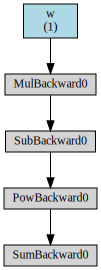

In [15]:
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = ptviz.make_dot(J,params=p)
out

# Exercícios

## Questões

1. O que acontece com o grafo computacional após execução do `backward()`?

## Atividades

1. Execute um passo de atualização do valor de w, pelo 
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.1 
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - execute a célula 1.3.1 e verifique o quanto que a perda J diminuiu
    
2. No trecho abaixo, uma rede bastante conhecida, `resnet18` contendo 18 camadas 
   é criada, tendo
   como entrada `xin`, resultando na saída `y`.
   
   Descomente a linha que cria a vizualização do grafo computacional e execute a
   célula para visualizar o grafo computacional da rede `resnet18`:

In [0]:
from torchvision import models
xin = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
y = resnet18(xin)

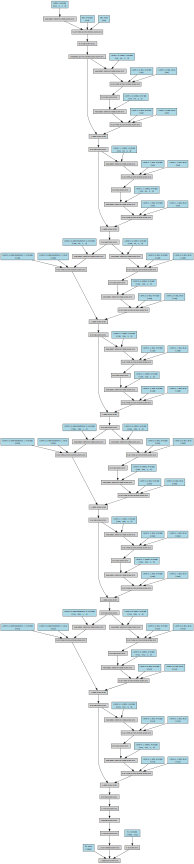

In [17]:
g = ptviz.make_dot(y, dict(resnet18.named_parameters()))
g

# Aprendizados com este notebook